Import modules

In [1]:
import aidbox # Communications with Aidbox
import aidbox.mdm as mdm # Creating MDM models
import altair as alt # Plot library used by splink
import splink.postgres.postgres_comparison_library as cl # Constructing splink comparisons
from splink.postgres.postgres_linker import PostgresLinker # splink linker for Aidbox
import pandas as pd

Configure altair library

In [2]:
alt.renderers.enable('mimetype');

# Connect to Aidbox

In [3]:
box = aidbox.Aidbox('http://localhost:8765', 'root', 'secret')

Verify connection

In [4]:
box.check()

{'version': '2212',
 'channel': 'edge',
 'commit': 'defc69181',
 'zen-fhir-version': '0.6.6-7',
 'timestamp': '2022-12-20T14:57:55Z'}

## Load sample data

First drop all existing Patient data

In [5]:
box.sql('truncate patient, patient_history')

0

Then load sample patients (from splink demos)

In [6]:
import sys
import subprocess 

In [7]:
sp = subprocess.Popen([sys.executable, '-m', 'http.server', '9090', '--directory', '../data'])
import time
time.sleep(1)

In [8]:
box.post_request(
    '$load',
    {
        'source': 'http://localhost:9090/fake1000.ndjson.gz'
    }
)

127.0.0.1 - - [10/Jan/2023 20:36:36] "GET /fake1000.ndjson.gz HTTP/1.1" 200 -


{'Patient': 1000}

In [9]:
sp.terminate()

## Create MDM model

Create empty MDM model for resource type

In [10]:
model = mdm.Model('Patient')

MDM model specifies how to extract data from FHIR into flat MDM table

Add fields

In [11]:
model['first_name'] = ['name', 0, 'given', 0]
model['surname'] = ['name', 0, 'family']
model['dob'] = ['birthDate']
model['city'] = ['address', 0, 'city']
model['email'] = ['telecom', {'system': 'email'}, 'value']
model['cluster'] = ['identifier', 0, 'value']

Right-hand side values are paths, where
- strings are keys in dictionary
- numbers are indices in list
- dictionaries are additional filters

Enable term frequencies for needed columns (in this case, only city)

In [12]:
model.enable_frequencies('city')

Apply model. This action create MDM table in Aidbox

In [13]:
model.apply(box)

{'result': 'ok'}

## Create splink linker

You need to set `unique_id_column_name` to `id`. Except this it is the usual splink settings object

In [14]:
settings = {
    "link_type": "dedupe_only",
    "unique_id_column_name": "id",
    "comparisons": [
        cl.exact_match("first_name"),
        cl.levenshtein_at_thresholds("surname"),
        cl.levenshtein_at_thresholds("dob", 1),
        cl.exact_match("city", term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("email"),
    ],
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
}

Create linker. Linker for Aidbox accepts three arguments: MDM model, Aidbox connection, and splink settings object

In [15]:
linker = PostgresLinker(model, box, settings)

Drop existing splink tables to start from scratch

In [16]:
linker.drop_splink_tables()

## ETL and learning

It is the same as splnk ETL and learning. Refer to splink documentation to learn how to use it.

Process from splink demo below (without descriptions)

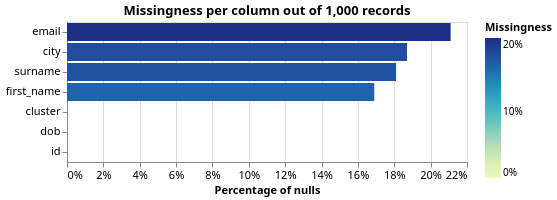

In [17]:
linker.missingness_chart()

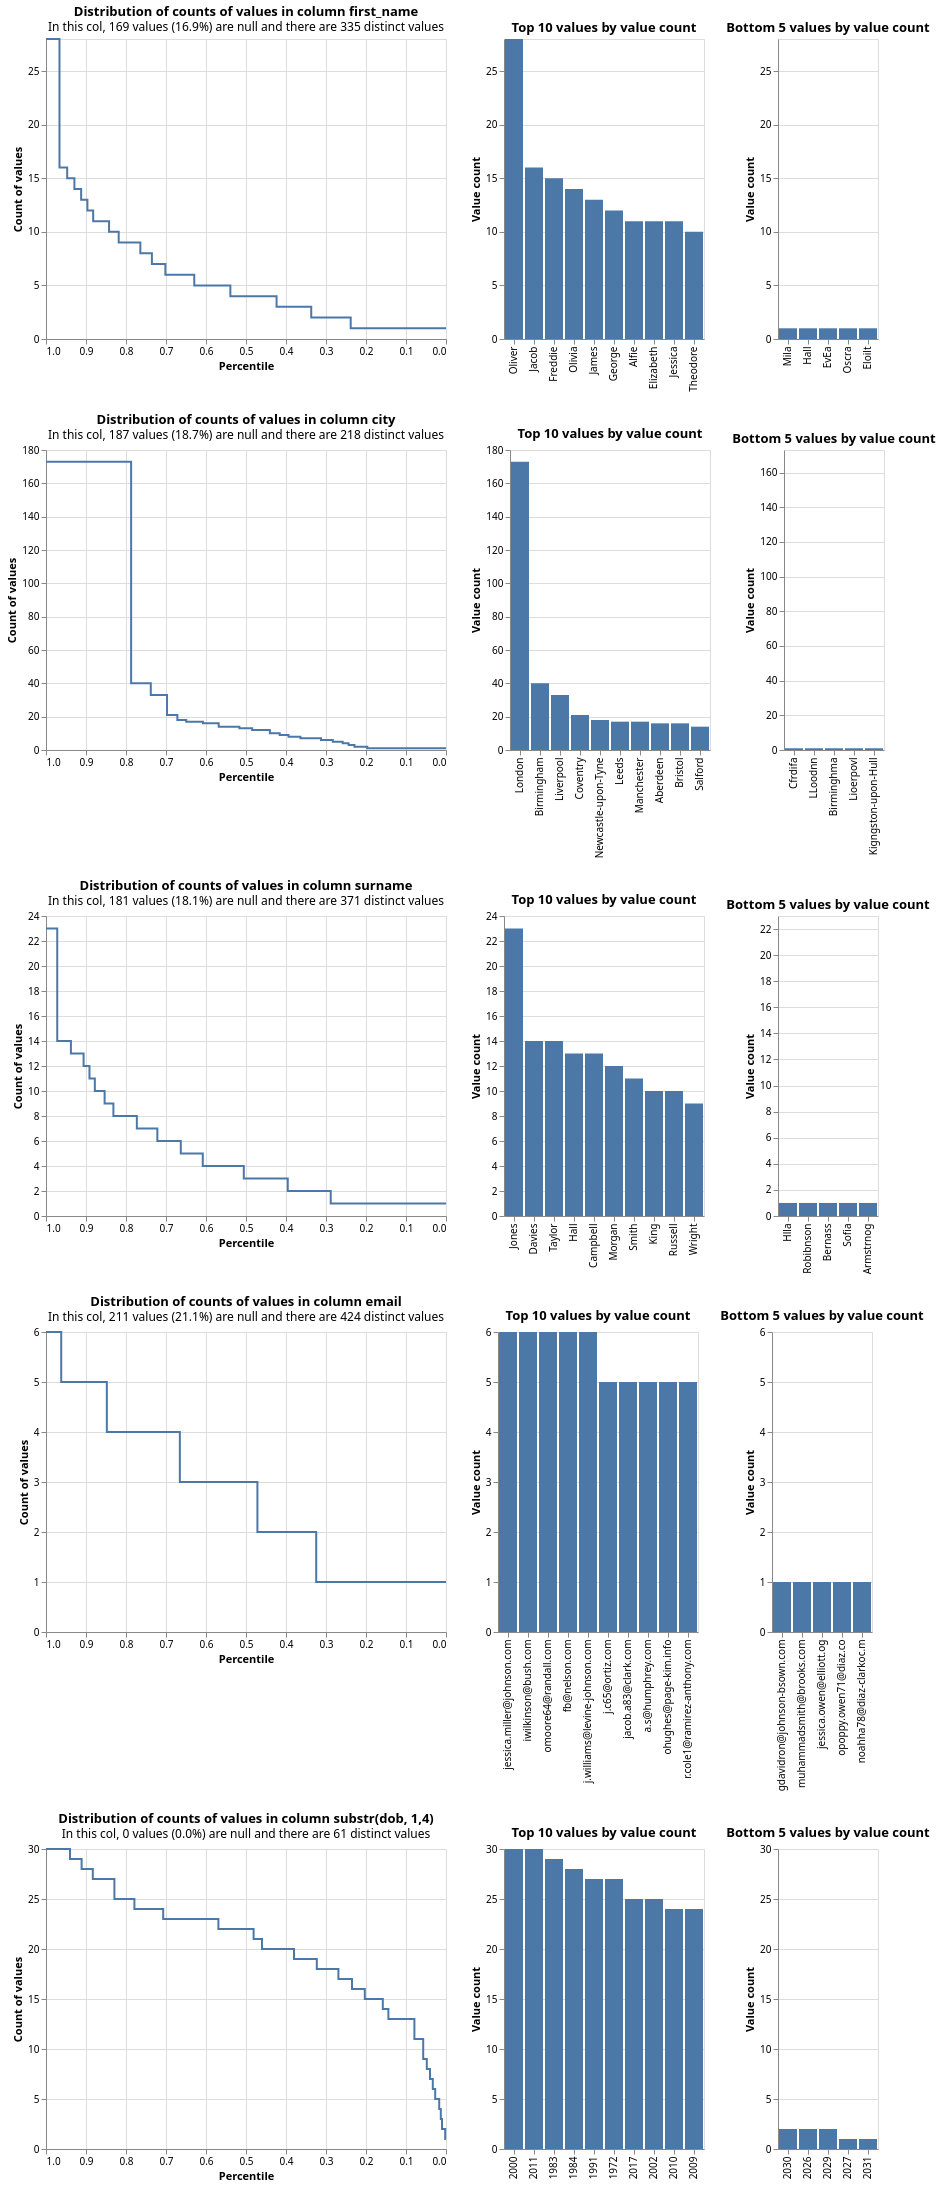

In [18]:
linker.profile_columns(["first_name", "city", "surname", "email", "substr(dob, 1,4)"], top_n=10, bottom_n=5)

In [19]:
blocking_rule_1 = "substr(l.first_name,1,1) = substr(r.first_name,1,1) and l.surname = r.surname"
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_1)
print(f"Number of comparisons generated by '{blocking_rule_1}': {count:,.0f}")

blocking_rule_2 = "l.surname = r.surname"
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_2)
print(f"Number of comparisons generated by '{blocking_rule_2}': {count:,.0f}")

blocking_rule_3 = "l.email = r.email"
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_3)
print(f"Number of comparisons generated by '{blocking_rule_3}': {count:,.0f}")

blocking_rule_3 = "l.city = r.city and l.first_name = r.first_name"
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_3)
print(f"Number of comparisons generated by '{blocking_rule_3}': {count:,.0f}")

Number of comparisons generated by 'substr(l.first_name,1,1) = substr(r.first_name,1,1) and l.surname = r.surname': 473
Number of comparisons generated by 'l.surname = r.surname': 1,638
Number of comparisons generated by 'l.email = r.email': 682
Number of comparisons generated by 'l.city = r.city and l.first_name = r.first_name': 315


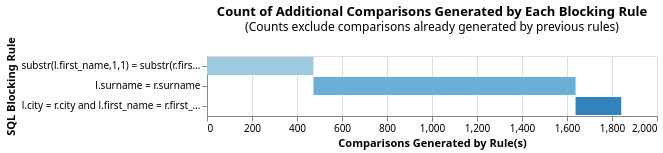

In [20]:
blocking_rules = [blocking_rule_1, blocking_rule_2, blocking_rule_3]
linker.cumulative_num_comparisons_from_blocking_rules_chart(blocking_rules)

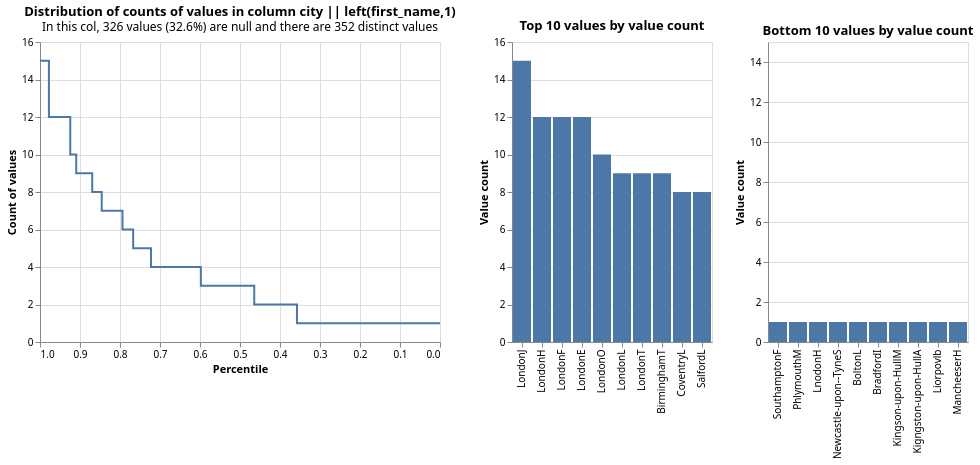

In [21]:
linker.profile_columns("city || left(first_name,1) ")

In [22]:
deterministic_rules = [
    "l.first_name = r.first_name and levenshtein(r.dob, l.dob) <= 1",
    "l.surname = r.surname and levenshtein(r.dob, l.dob) <= 1",
    "l.first_name = r.first_name and levenshtein(r.surname, l.surname) <= 2",
    "l.email = r.email"
]

linker.estimate_probability_two_random_records_match(deterministic_rules, recall=0.7)

Probability two random records match is estimated to be  0.00333.
This means that amongst all possible pairwise record comparisons, one in 300.13 are expected to match.  With 499,500 total possible comparisons, we expect a total of around 1,664.29 matching pairs


In [23]:
linker.estimate_u_using_random_sampling(target_rows=1e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - city (no m values are trained).
    - email (no m values are trained).


In [24]:
training_blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_fname_sname = linker.estimate_parameters_using_expectation_maximisation(training_blocking_rule)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.first_name = r.first_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - dob
    - city
    - email

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - first_name
    - surname

Iteration 1: Largest change in params was -0.514 in the m_probability of dob, level `Exact match`
Iteration 2: Largest change in params was 0.0474 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.0212 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.0113 in probability_two_random_records_match
Iteration 5: Largest change in params was 0.00694 in probability_two_random_records_match
Iteration 6: Largest change in params was 0.00463 in probability_two_random_records_match
Iteration 7: Largest change in params was 0.00328 in p

In [25]:
training_blocking_rule = "l.dob = r.dob"
training_session_dob = linker.estimate_parameters_using_expectation_maximisation(training_blocking_rule)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.dob = r.dob

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - city
    - email

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Iteration 1: Largest change in params was -0.392 in the m_probability of surname, level `Exact match`
Iteration 2: Largest change in params was 0.137 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.0416 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.0171 in probability_two_random_records_match
Iteration 5: Largest change in params was 0.00853 in probability_two_random_records_match
Iteration 6: Largest change in params was 0.0047 in probability_two_random_records_match
Iteration 7: Largest change in params was 0.00274 in probability_two_random_records_match
It

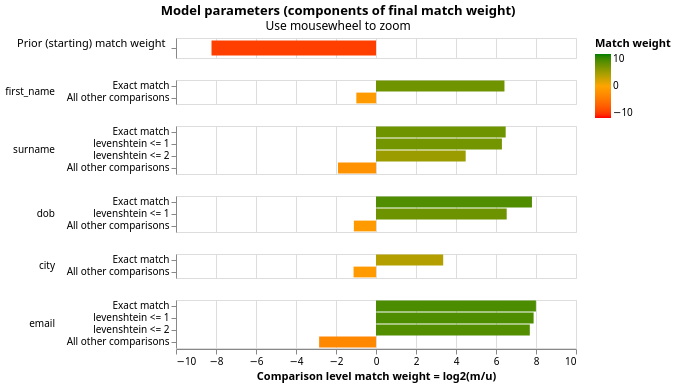

In [26]:
linker.match_weights_chart()

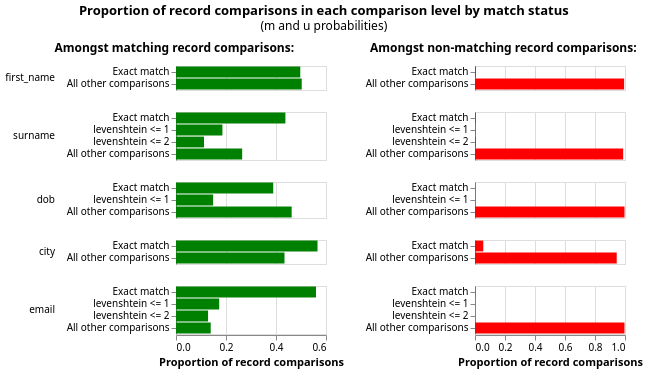

In [27]:
linker.m_u_parameters_chart()

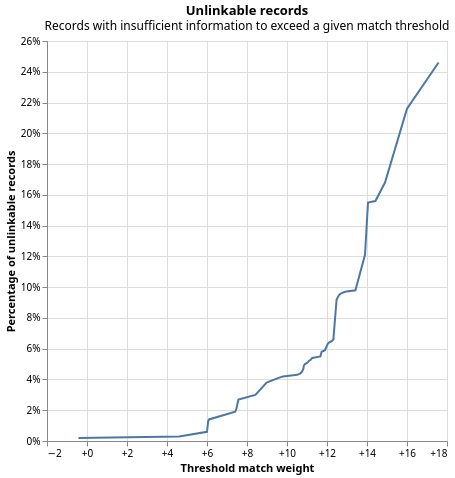

In [28]:
linker.unlinkables_chart()

In [29]:
box.sql('select round(1.433, 2)')

[{'round': 1.43}]

In [30]:
df_predictions = linker.predict(threshold_match_probability=0.2)
df_predictions.as_pandas_dataframe(limit=5)

,match_weight,match_probability,id_l,id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,surname_l,surname_r,...,gamma_city,tf_city_l,tf_city_r,bf_city,bf_tf_adj_city,email_l,email_r,gamma_email,bf_email,match_key
0,12.291082,0.999801,0,3,Robert,Robert,1,85.803382,Alan,Alen,...,-1,NaN,0.00738,1.000000,1.000000,robert255@smith.net,None,-1,1.000000,0
1,16.907079,0.999992,0,1,Robert,Robert,1,85.803382,Alan,Allen,...,-1,NaN,NaN,1.000000,1.000000,robert255@smith.net,roberta25@smith.net,1,206.571839,0
2,11.027969,0.999521,1,3,Robert,Robert,1,85.803382,Allen,Alen,...,-1,NaN,0.00738,1.000000,1.000000,roberta25@smith.net,None,-1,1.000000,0
3,25.736754,1.000000,101,105,Alfie,Alfie,1,85.803382,Griffiths,Griffiths,...,1,0.01476,0.01476,10.264354,3.736248,a.griffiths@garner-bridges.com,a.griffiths@garner-bridges.com,3,255.301620,0
4,2.263633,0.827645,101,103,Alfie,Alfie,1,85.803382,Griffiths,Griffihs,...,0,0.01476,0.00123,0.459274,1.000000,a.griffiths@garner-bridges.com,None,-1,1.000000,0


In [31]:
clusters = linker.cluster_pairwise_predictions_at_threshold(df_predictions, threshold_match_probability=0.5)
clusters.as_pandas_dataframe(limit=10)

Completed iteration 1, root rows count 13
Completed iteration 2, root rows count 1
Completed iteration 3, root rows count 0


,cluster_id,city,cluster,dob,email,first_name,id,surname,tf_city
0,0,None,0,1971-06-24,robert255@smith.net,Robert,0,Alan,NaN
1,0,None,0,1971-05-24,roberta25@smith.net,Robert,1,Allen,NaN
2,10,Portsmouth,3,2015-03-03,evied56@harris-bailey.net,None,10,Dean,0.01722
3,100,None,28,2009-08-25,e.e@day.com,Eleanor,100,None,NaN
4,101,Plymouth,29,2008-05-07,a.griffiths@garner-bridges.com,Alfie,101,Griffiths,0.01476
5,101,Plymouth,29,2008-05-07,a.griffiths@garner-bridges.com,Alfie,102,None,0.01476
6,101,Plyoutm,29,2009-04-07,None,Alfie,103,Griffihs,0.00123
7,104,Plymouth,29,2008-05-07,a.griffiths@garner-bridges.com,Griffiths,104,Alfie,0.01476
8,101,Plymouth,29,2008-05-07,a.griffiths@garner-bridges.com,Alfie,105,Griffiths,0.01476
9,106,Bimminghar,30,2005-08-20,maiie.walsoh@hodge.com,Miaisie,106,Walsh,0.00123


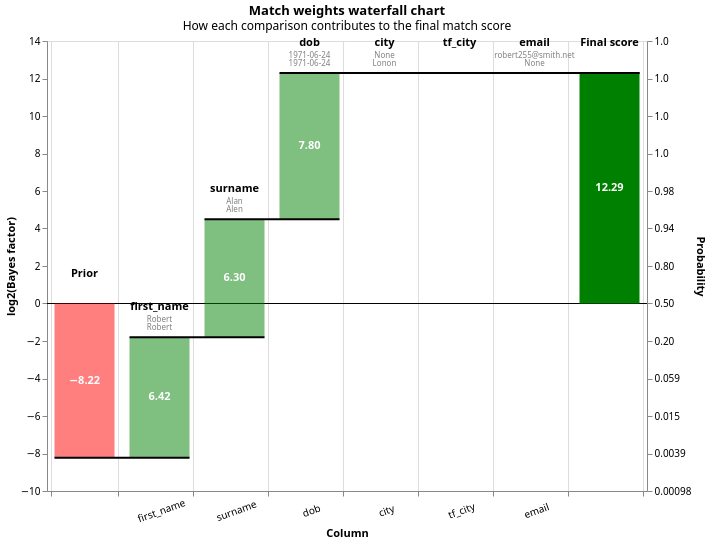

In [32]:
records_to_view  = df_predictions.as_record_dict(limit=5)
linker.waterfall_chart(records_to_view, filter_nulls=False)

In [33]:
linker.comparison_viewer_dashboard(df_predictions, "scv.html", overwrite=True)

# You can view the scv.html file in your browser, or inline in a notbook as follows
from IPython.display import IFrame
IFrame(
    src="./scv.html", width="100%", height=1200
)  

In [34]:
df_clusters = linker.cluster_pairwise_predictions_at_threshold(df_predictions, threshold_match_probability=0.5)

linker.cluster_studio_dashboard(df_predictions, df_clusters, "cluster_studio.html", sampling_method="by_cluster_size", overwrite=True)

# You can view the scv.html file in your browser, or inline in a notbook as follows
from IPython.display import IFrame
IFrame(
    src="./cluster_studio.html", width="100%", height=1200
)

Completed iteration 1, root rows count 13
Completed iteration 2, root rows count 1
Completed iteration 3, root rows count 0


# Export zen-lang edn for Aidbox project

In [35]:
linker.save_zen_model_edn('model.edn')

In [36]:
model.as_dict()

{'fields': {'first_name': ['name', 0, 'given', 0],
  'surname': ['name', 0, 'family'],
  'dob': ['birthDate'],
  'city': ['address', 0, 'city'],
  'email': ['telecom', {'system': 'email'}, 'value'],
  'cluster': ['identifier', 0, 'value']},
 'use-frequencies-for': ['city'],
 'resource-type': 'Patient'}

In [37]:
import edn_format as edn

In [38]:
edn.loads('{:a #{:b}}')

{Keyword(a): frozenset({Keyword(b)})}